In [1]:
import torch
from torch import nn

from src.data.catenets_datasets.simulated_data import simulate_treatment_setup
from src.NN.d2l import d2l_Module,d2l_DataModule,d2l_Trainer
from src.NN.data import get_IPW_psuedo_generator,SyntheticPseudo_data_loader,Synthetic_data_loader
from src.NN.networks import Base_Net
from functools import partial

In [2]:
synth_func = partial(simulate_treatment_setup,
                    n_t=10,
                    n_w=0,
                    n_c=0,
                    n_o=10,
                    covariate_model_params={"correlated": False},
                    propensity_model_params={"xi": 0.5},
                    mu_1_model_params={"withbase": True},
                    seed = torch.randint(0,10**6,(1,)).item(),error_sd=0)
pseudo_synth_func = get_IPW_psuedo_generator(synth_func)

In [3]:
X, y, w, p, cate = synth_func(100)

In [4]:
y.mean()

tensor(-5.9605e-09)

In [5]:
class Adjust_Net(d2l_Module):  #@save

    """NN using adjustment for Pseudo Outcomes"""

    def __init__(self, lr ,xi=0.5 , wd=0.1 , hidden_layer_lists = ([256],[256])):

        super().__init__()
        self.save_hyperparameters()

        NN_layer_lists = ([],[])

        for i,layer_list in enumerate(hidden_layer_lists):
            for hidden_vals in layer_list:

                NN_layer_lists[i].append(nn.LazyLinear(hidden_vals))
                NN_layer_lists[i].append(nn.ELU())
            NN_layer_lists[i].append(nn.LazyLinear(1))

        self.net1 = nn.Sequential(*NN_layer_lists[0])
        self.net2 = nn.Sequential(*NN_layer_lists[1])
    
    def forward(self, X):
        return self.net1(X[:,:-1]) + ((X[:,-1:]-self.xi)/(self.xi*(1-self.xi)))*self.net2(X[:,:-1])
    
    def pred_CATE(self, X_no_T):
        return self.net1(X_no_T) 
    
    def loss(self, y_hat, y):
        fn = nn.MSELoss()
        return fn(y_hat, y)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),weight_decay=self.wd, lr=self.lr)

In [6]:
X,pseudo,cate,t = pseudo_synth_func(10000)
fn = nn.MSELoss()

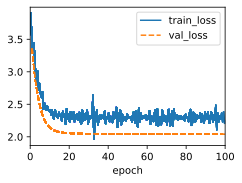

In [7]:
data = SyntheticPseudo_data_loader(pseudo_synth_func,num_train=2000,num_val=100,batch_size=100)
model = Base_Net(hidden_layer_list=[200,200],lr=0.001)
trainer = d2l_Trainer(max_epochs=100)
trainer.fit(model, data)

In [8]:
fn(torch.zeros_like(cate),cate),fn(torch.zeros_like(pseudo),pseudo)

(tensor(2.1602), tensor(3.9996))

In [9]:
fn(model(X),cate),fn(model(X),pseudo)

/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


(tensor(0.3638, grad_fn=<MseLossBackward0>),
 tensor(2.1609, grad_fn=<MseLossBackward0>))

In [28]:
model(X).std()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5000x2 and 25x200)

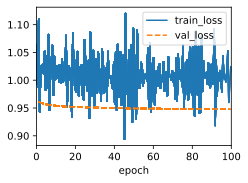

In [10]:
data = Synthetic_data_loader(synth_func,num_train=2000,num_val=400)
model_base = Base_Net(hidden_layer_list=[200,200],lr=0.001)
trainer = d2l_Trainer(max_epochs=100)
trainer.fit(model_base, data)

In [11]:
X_ones = torch.concat([X,torch.ones((len(X),1))],dim=1)
X_zeros = torch.concat([X,torch.ones((len(X),1))],dim=1)

fn((model_base(X_ones)-model_base(X_zeros)),cate),

(tensor(2.1602, grad_fn=<MseLossBackward0>),)

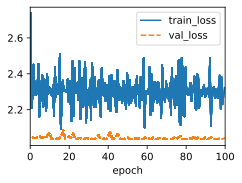

In [12]:
data_T = SyntheticPseudo_data_loader(pseudo_synth_func,num_train=2000,num_val=100,batch_size=200,use_T=True)
adjust_model = Adjust_Net(wd=0.00,lr=0.1,hidden_layer_lists=([200,200,200],[200,200,200]))
trainer = d2l_Trainer(max_epochs=100)
trainer.fit(adjust_model, data_T)

In [13]:
fn(adjust_model.pred_CATE(X),cate)

tensor(0.3641, grad_fn=<MseLossBackward0>)

In [14]:
adjust_model.pred_CATE(X).std()

tensor(0.0116, grad_fn=<StdBackward0>)

In [15]:
adjust_model.pred_CATE(X).mean()

tensor(1.2641, grad_fn=<MeanBackward0>)

In [16]:
cate.mean(),cate.std()

(tensor(1.3425), tensor(0.5982))

In [18]:
from src.NN.data import trial_data_generator

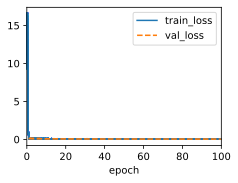

In [19]:
data = Synthetic_data_loader(trial_data_generator,num_train=5000,num_val=400,batch_size=100,use_T=False)
model_base = Base_Net(hidden_layer_list=[200,200],lr=0.001)
trainer = d2l_Trainer(max_epochs=100)
trainer.fit(model_base, data)

In [21]:
X,y,t,_,_ =  trial_data_generator(5000)

In [24]:
fn(model_base(X),y)

tensor(0.0313, grad_fn=<MseLossBackward0>)

In [26]:
y.mean(),y.std()

(tensor(4.3205), tensor(3.9463))

In [27]:
model_base(X).mean(),model_base(X).std()

(tensor(4.3041, grad_fn=<MeanBackward0>),
 tensor(3.9315, grad_fn=<StdBackward0>))